In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
import nltk
import re
import string

In [2]:
fake = 'Fake.csv'  #file with fake news data
real = 'True.csv'  #file with real news data

fake_df = pd.read_csv(fake) #create initial dfs
real_df = pd.read_csv(real) 

display(fake_df)
display(real_df)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [3]:
#check for null values
null_rows_fake = fake_df[fake_df.isnull().any(axis=1)]
print("Rows with null values in Fake DataFrame:")
print(null_rows_fake)

null_rows_real = real_df[real_df.isnull().any(axis=1)]
print("Rows with null values in Real DataFrame:")
print(null_rows_real)

Rows with null values in Fake DataFrame:
Empty DataFrame
Columns: [title, text, subject, date]
Index: []
Rows with null values in Real DataFrame:
Empty DataFrame
Columns: [title, text, subject, date]
Index: []


In [4]:
#add label column
fake_df['label'] = 1
real_df['label'] = 0

In [5]:
#combine real and fake df
combined_df = pd.concat([fake_df, real_df], ignore_index=True)

display("Combined DataFrame:")
display(combined_df)

'Combined DataFrame:'

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1
...,...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",0
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",0
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",0
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",0


In [6]:
duplicates = combined_df[combined_df.duplicated(keep=False)]

#drop duplicates considering all columns
combined_df = combined_df.drop_duplicates(keep='first')

print("DataFrame after dropping duplicate rows considering all columns:")
display(combined_df)

DataFrame after dropping duplicate rows considering all columns:


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1
...,...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",0
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",0
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",0
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",0


In [7]:
combined_df['content'] = combined_df['title'].astype(str) + ' ' + combined_df['text'].astype(str)

#drop unnecessary columns after combining title/text
combined_df_final = combined_df[['content', 'label']].copy()

display(combined_df_final)

,content,label
0,Donald Trump Sends Out Embarrassing New Year’...,1
1,Drunk Bragging Trump Staffer Started Russian ...,1
2,Sheriff David Clarke Becomes An Internet Joke...,1
3,Trump Is So Obsessed He Even Has Obama’s Name...,1
4,Pope Francis Just Called Out Donald Trump Dur...,1
...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,0
44894,LexisNexis withdrew two products from Chinese ...,0
44895,Minsk cultural hub becomes haven from authorit...,0
44896,Vatican upbeat on possibility of Pope Francis ...,0


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
import string
import contractions

def normalize(text):
    #initialize lemmatizer
    lemmatizer = WordNetLemmatizer()
    #convert to lowercase
    text = text.lower()
    #remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    #expand contractions
    text = contractions.fix(text)
    #remove punctuation (including apostrophes) and numbers
    text = re.sub(r"[^\w\s]", '', text)
    #remove numbers
    text = re.sub(r'\d+', '', text)
    #remove extra whitespace
    text = ' '.join(text.split())
    #remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    #lemmatize the text
    text = ' '.join(lemmatizer.lemmatize(word, pos='v') for word in text.split())
    
    return text

#apply function
combined_df_final['content'] = combined_df_final['content'].apply(normalize)

In [9]:
display(combined_df_final)
print(combined_df_final['label'].value_counts())

,content,label
0,donald trump send embarrass new years eve mess...,1
1,drink brag trump staffer start russian collusi...,1
2,sheriff david clarke become internet joke thre...,1
3,trump obsess even obamas name cod website imag...,1
4,pope francis call donald trump christmas speec...,1
...,...,...
44893,fully commit nato back new yous approach afgha...,0
44894,lexisnexis withdraw two products chinese marke...,0
44895,minsk cultural hub become authorities minsk re...,0
44896,vatican upbeat possibility pope francis visit ...,0


label
1    23478
0    21211
Name: count, dtype: int64


In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler

#split data into training and testing sets
train_df, test_df = train_test_split(combined_df_final, test_size=0.2, random_state=42)

train_content = train_df['content'].tolist()
test_content = test_df['content'].tolist()

#initialize tokenizer and convert texts to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_content)

#define vocab size
vocab_size = len(tokenizer.word_index) + 1 
print(f"Vocabulary size: {vocab_size}")

#convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_content)
test_sequences = tokenizer.texts_to_sequences(test_content)

#max length
sequence_lengths = [len(seq) for seq in train_sequences + test_sequences]
max_length = int(np.percentile(sequence_lengths, 95))
print(f"Max sequence length: {max_length}")

embedding_dim = 100  # Embedding dimension to be used
print(f"Embedding dim: {embedding_dim}")

#pad sequences
X_train = pad_sequences(train_sequences, maxlen=max_length)
X_test = pad_sequences(test_sequences, maxlen=max_length)

#define labels
y_train = np.array(train_df['label'])
y_test = np.array(test_df['label'])

#print shapes of training and testing data (used for earlier debug)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Vocabulary size: 179073
Max sequence length: 527
Embedding dim: 100
X_train shape: (35751, 527)
y_train shape: (35751,)
X_test shape: (8938, 527)
y_test shape: (8938,)


In [11]:
from numpy import zeros
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Dropout, Conv1D, MaxPooling1D, BatchNormalization, Lambda
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

#initialize model
model = Sequential()
#embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, input_shape=(max_length,)))
#Conv1D layer
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
#MaxPooling1D layer
model.add(MaxPooling1D(pool_size=2))
#dropout layer
model.add(Dropout(0.3))
#flatten layer
model.add(Flatten())
#dense layer
model.add(Dense(64, activation='relu'))
#final dense layer
model.add(Dense(1, activation='sigmoid'))

#compile network
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#print model summary
model.summary()

/Users/raylesser/anaconda3/envs/tf_macos_clean/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/Users/raylesser/anaconda3/envs/tf_macos_clean/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-08-08 22:31:55.445343: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-08-08 22:31:55.445360: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-08-08 22:31:55.445364: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-08-08 22:31:55.445379: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting t

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 527, 100)       │    17,907,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 523, 64)        │        32,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 261, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 261, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16704)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,069,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,008,549 (72.51 MB)

 Trainable params: 19,008,549 (72.51 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from sklearn.metrics import classification_report, accuracy_score

#early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

#fit the network with validation data for early stopping and checkpoints
history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

#evaluate on training set
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print('Train Accuracy: %f' % (train_acc * 100))

#evaluate on test set
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %f' % (acc * 100))

Epoch 1/10


2024-08-08 22:31:55.961612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


894/894 - 94s - 105ms/step - accuracy: 0.9665 - loss: 0.0777 - val_accuracy: 0.9964 - val_loss: 0.0132
Epoch 2/10
894/894 - 81s - 90ms/step - accuracy: 0.9985 - loss: 0.0049 - val_accuracy: 0.9936 - val_loss: 0.0221
Epoch 3/10
894/894 - 40s - 45ms/step - accuracy: 0.9991 - loss: 0.0038 - val_accuracy: 0.9926 - val_loss: 0.0438
Epoch 4/10
894/894 - 39s - 43ms/step - accuracy: 0.9990 - loss: 0.0052 - val_accuracy: 0.9972 - val_loss: 0.0137
Train Accuracy: 99.851751
Test Accuracy: 99.597228


In [13]:
#predict on train set
predictions = model.predict(X_train)
y_pred_train_classes = (predictions > 0.5).astype("int32")

#print classification report
report = classification_report(y_train, y_pred_train_classes)
print(report)

1118/1118 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17011
           1       1.00      1.00      1.00     18740

    accuracy                           1.00     35751
   macro avg       1.00      1.00      1.00     35751
weighted avg       1.00      1.00      1.00     35751



In [14]:
#evaluating the model
loss = model.evaluate(X_test, y_test)

print(f'Test Loss: {loss}')

#predict on test set
predictions = model.predict(X_test)
y_pred_test_classes = (predictions > 0.5).astype("int32")

#print classification report
report = classification_report(y_test, y_pred_test_classes)
print(report)

280/280 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9969 - loss: 0.0106
Test Loss: [0.014402114786207676, 0.9959722757339478]
280/280 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4200
           1       1.00      1.00      1.00      4738

    accuracy                           1.00      8938
   macro avg       1.00      1.00      1.00      8938
weighted avg       1.00      1.00      1.00      8938



In [15]:
#same steps as earlier for new data

unlabeled = 'NLP AE2 test.csv'  
submit = 'NLP AE2 submit.csv'  

unlabeled_df = pd.read_csv(unlabeled) 
submit_df = pd.read_csv(submit)  

labeled_df = unlabeled_df.copy()
labeled_df['label'] = submit_df['label'].values

labeled_df['content'] = labeled_df['title'].astype(str) + ' ' + labeled_df['text'].astype(str)

deploy_df = labeled_df[['content', 'label']].copy()

display(deploy_df)

,content,label
0,"Specter of Trump Loosens Tongues, if Not Purse...",0
1,Russian warships ready to strike terrorists ne...,1
2,#NoDAPL: Native American Leaders Vow to Stay A...,0
3,"Tim Tebow Will Attempt Another Comeback, This ...",1
4,Keiser Report: Meme Wars (E995) 42 mins ago 1 ...,1
...,...,...
5195,The Bangladeshi Traffic Jam That Never Ends - ...,0
5196,John Kasich Signs One Abortion Bill in Ohio bu...,1
5197,"California Today: What, Exactly, Is in Your Su...",0
5198,300 US Marines To Be Deployed To Russian Borde...,1


In [16]:
#apply text normalization function
deploy_df['content'] = deploy_df['content'].apply(normalize)

deploy_content = deploy_df['content'].tolist()

#convert texts to sequences
deploy_sequences = tokenizer.texts_to_sequences(deploy_content)

#pad sequences
X_deploy = pad_sequences(deploy_sequences, maxlen=max_length)

#define labels
y_deploy = np.array(deploy_df['label'])

In [17]:
#evaluating the model
loss = model.evaluate(X_deploy, y_deploy)

print(f'Test Loss: {loss}')

#predict on new data
predictions = model.predict(X_deploy)
y_pred_deploy_classes = (predictions > 0.5).astype("int32")

#print classification report
report = classification_report(y_deploy, y_pred_deploy_classes)
print(report)

163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6026 - loss: 1.6787
Test Loss: [1.7041383981704712, 0.5994230508804321]
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.67      0.21      0.33      2339
           1       0.59      0.91      0.72      2861

    accuracy                           0.60      5200
   macro avg       0.63      0.56      0.52      5200
weighted avg       0.63      0.60      0.54      5200



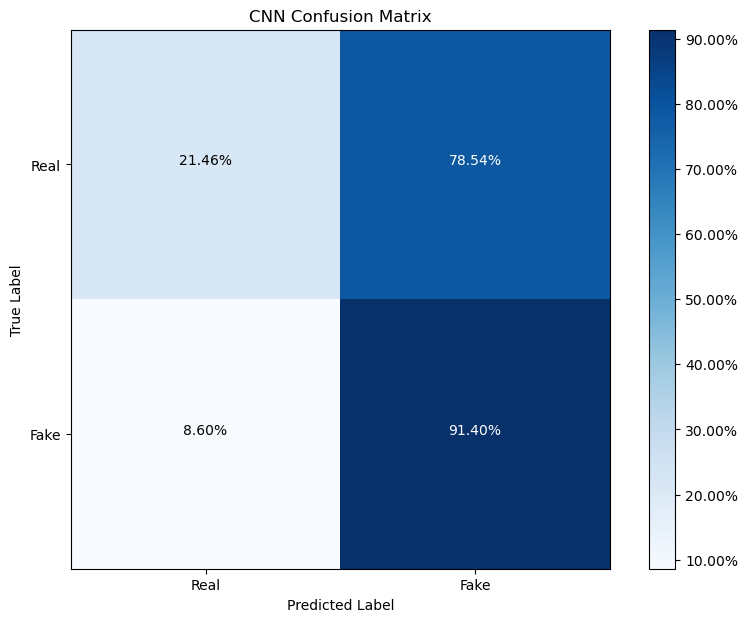

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#creating the confusion matrix
cm = confusion_matrix(y_deploy, y_pred_deploy_classes)

#convert to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

#plotting the confusion matrix
labels = ['Real', 'Fake']
plt.figure(figsize=(10, 7))
plt.imshow(cm_percentage, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('CNN Confusion Matrix')
plt.colorbar(format='%.2f%%')

tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

#adding text annotations
thresh = cm_percentage.max() / 2.
for i, j in np.ndindex(cm_percentage.shape):
    plt.text(j, i, f'{cm_percentage[i, j]:.2f}%',
             horizontalalignment="center",
             color="white" if cm_percentage[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
import keras_tuner as kt

#define the model with hyperparameters
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=hp.Int('embedding_dim', min_value=50, max_value=300, step=50), 
                        input_length=max_length))
    model.add(Conv1D(filters=hp.Int('filters', min_value=32, max_value=128, step=32), 
                     kernel_size=hp.Int('kernel_size', min_value=3, max_value=7, step=2), 
                     activation='relu'))
    model.add(MaxPooling1D(pool_size=hp.Int('pool_size', min_value=2, max_value=4, step=1)))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Flatten())
    model.add(Dense(hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

#initialize tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=1,
    directory='my_dir',  # Directory to save results
    project_name='my_project'
)

#print the search space summary
tuner.search_space_summary()

#set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

#perform hyperparameter tuning
tuner.search(X_train, y_train, 
             epochs=10, 
             batch_size=32, 
             validation_split=0.2, 
             callbacks=[early_stopping, model_checkpoint])

#print the best hyperparameters
tuner.results_summary()

In [ ]:
#get the best model
best_model = tuner.get_best_models(num_models=1)[0]

#predict on test set
y_pred = (best_model.predict(X_test) > 0.5).astype(int).flatten()

#generate and print classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)